# Moving *Towards* an adv label

In [13]:
from scipy.misc import imresize, imread, imshow
import numpy as np
from skimage import io
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import os
import scipy.ndimage

In [14]:
model_id = 'keras_eg_alldrop'
work_dir = '/dccstor/dlw/ambrish/data/'+model_id+'/towards'

In [15]:
mc_acc = np.load(os.path.join(work_dir,'tmc_acc_e.npy'))
std_acc = np.load(os.path.join(work_dir,'tstd_acc_e.npy'))
eps = np.load(os.path.join(work_dir,'te.npy'))
mean_e = np.load(os.path.join(work_dir,'tmean_e.npy'))
mean_stddr_e = np.load(os.path.join(work_dir,'tmean_stddr_e.npy'))
std_e = np.load(os.path.join(work_dir,'tstd_e.npy'))
var_ratio_e = np.load(os.path.join(work_dir,'tvar_ratio_e.npy'))
stddr_preds_e = np.load(os.path.join(work_dir,'tstddr_preds_e.npy'))
stoch_preds_e = np.load(os.path.join(work_dir,'tstoch_preds_e.npy'))
#save_adv_e = np.load(os.path.join(work_dir,'save_adv_e.npy'))

### Experiment Details

 - **Adversrial images were generated for the CIFAR test set consisting of 10000 images using FastGradientSign**
 - **FastGradSign - moving away; eps was varied from 0.0 to 0.1 with increments of 0.002**
 - **Labels taken for keras-eg-alldrop with std-droput interprtation**
 - ** 100 samples were taken for mc-droput **
 

## Accuracy with respect to adversarial label

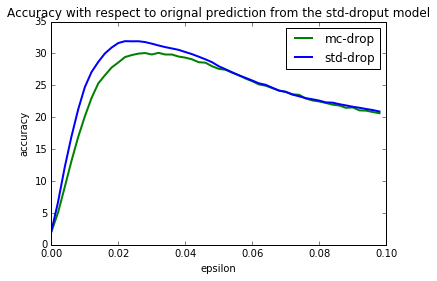

In [26]:
plt.plot(eps,100*mc_acc,color='g',linewidth=2, label='mc-drop')
plt.hold(True)
plt.plot(eps,100*std_acc,color='b',linewidth=2, label='std-drop')
plt.legend()
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.title('Accuracy with respect to orignal prediction from the std-droput model')

 - **The above plot compares accruracy with respect to predctions from standard_droput model for different epsilons used in fgsm**
 - **As the label is taken from standard dropout model, the accuracy of mc_droput is lower**
 - **However, it is evident that the rate of change in accuracy is lower for mc_droput**

## Average confidence in adversarial label

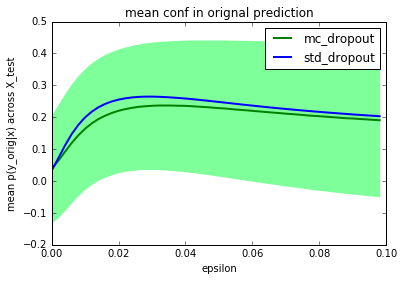

In [18]:
plt.plot(eps,mean_e,color='g',linewidth=2, label='mc_dropout')
plt.hold(True)
plt.fill_between(eps, mean_e-2.0*np.sqrt(std_e), mean_e+2.0*np.sqrt(std_e),
    alpha=1, edgecolor='#3F7F4C', facecolor='#7EFF99',
    linewidth=0)

plt.plot(eps,mean_stddr_e,color='b',linewidth=2, label='std_dropout')
plt.legend()
plt.xlabel('epsilon')
plt.ylabel('mean p(y_adv|x) across X_test')
plt.title('mean conf in adversarial prediction')

## Average confidence orignal label

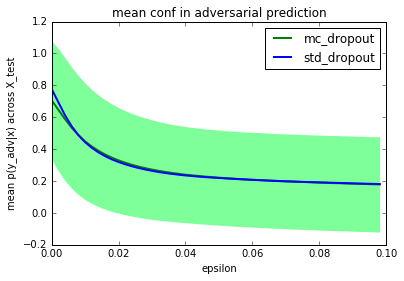

In [41]:
# mean for the orignal label
from keras.utils import np_utils
#orig_preds = np.argmax(stddr_preds_e[0],axis=1)
orig_preds = np_utils.to_categorical(np.argmax(stddr_preds_e[0],axis=1),10)

mc_means = []
mc_vars = []
stddr_means = []

for i in range(stoch_preds_e.shape[0]):
    '''for every eps'''
    mc_means.append(np.mean(np.sum(np.multiply(orig_preds,np.mean(stoch_preds_e[i],axis=(0))),axis=1)))
    mc_vars.append(np.mean(np.sum(np.multiply(orig_preds,np.var(stoch_preds_e[i],axis=(0))),axis=1)))
    stddr_means.append(np.mean(np.sum(np.multiply(orig_preds,stddr_preds_e[i]),axis=1)))

plt.plot(eps,mc_means,color='g',linewidth=2, label='mc_dropout')
plt.hold(True)
plt.fill_between(eps, mc_means-2.0*np.sqrt(mc_vars), mc_means+2.0*np.sqrt(mc_vars),
    alpha=1, edgecolor='#3F7F4C', facecolor='#7EFF99',
    linewidth=0)

plt.plot(eps,stddr_means,color='b',linewidth=2, label='std_dropout')
plt.legend()
plt.xlabel('epsilon')
plt.ylabel('mean p(y_adv|x) across X_test')
plt.title('mean conf in adversarial prediction')

In [50]:
np.sum(np.multiply(orig_preds,np.mean(stoch_preds_e[0],axis=(0))),axis=1).shape
mc_vars[0]

0.034446526332768873

- **p(y_orig|x_adv) was computed for adverarial images generated for the X_test**
- **Here the original label is taken from std_dropout model**
- **+-2.0 std_deviation is plotted only as a diagniostic tool. **

## Variance in p(label = y_adv|adv_x) averaged across all adversarial images of X_test

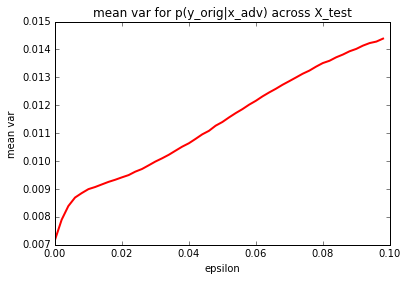

In [19]:
plt.plot(eps,(std_e),color='r',linewidth=2)
plt.xlabel('epsilon')
plt.ylabel('mean var')
plt.title('mean var for p(y_orig|x_adv) across X_test')

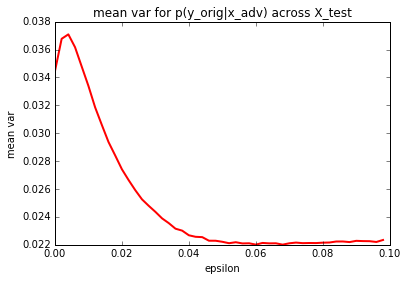

In [43]:
plt.plot(eps,(mc_vars),color='r',linewidth=2)
plt.xlabel('epsilon')
plt.ylabel('mean var')
plt.title('mean var for p(y_orig|x_adv) across X_test')

## Avergage Variation Ratio across all adversrial images of X_test

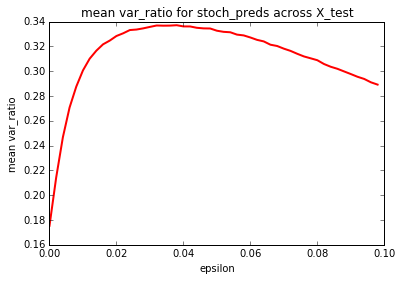

In [8]:
plt.plot(eps,var_ratio_e,color='r',linewidth=2)
plt.xlabel('epsilon')
plt.ylabel('mean var_ratio')
plt.title('mean var_ratio for stoch_preds across X_test')

In [9]:
print(stoch_preds_e.shape)

(50, 100, 10000, 10)


## Max(p(y|adv_x)) averaged across all images, where p(y|x) is computed as MC estimate 

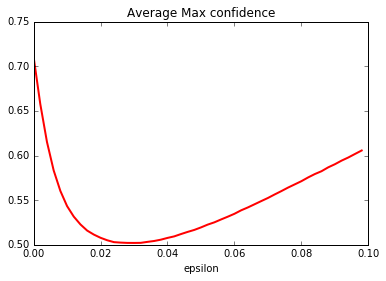

In [10]:
def compute_stats(x):
    #shape(100,10)
    #return 1.0 - scipy.stats.mstats.mode(np.argmax(x,axis=1),axis=None)[1]/100.0
    return np.max(np.mean(x,axis=0))
    
stats = np.zeros((stoch_preds_e.shape[0],stoch_preds_e.shape[2]))

for i in range(stoch_preds_e.shape[0]):
    '''for every eps'''
    for j in range(stoch_preds_e.shape[2]):
        '''for every image'''
        stats[i,j] = compute_stats(stoch_preds_e[i,:,j,:])

plt.plot(eps,np.mean(stats,axis=1),linewidth=2,color='r')
plt.xlabel('epsilon')
plt.title('Average Max confidence')

## Average entropy across probability vectors (further averages across adversrial images of X_test)

/dccstor/dlw/virtual_environments/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/dccstor/dlw/virtual_environments/python3.4/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


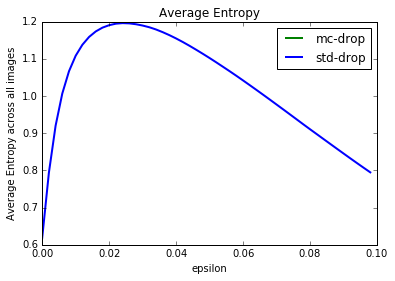

In [11]:
def compute_stats(x):
    #np.mean([scipy.stats.entropy(p_vec) for p_vec in x])
    return np.mean(np.sum(-x*np.log(x),axis=1),axis=0)
    
stats = np.zeros((stoch_preds_e.shape[0],stoch_preds_e.shape[2]))

for i in range(stoch_preds_e.shape[0]):
    '''for every eps'''
    for j in range(stoch_preds_e.shape[2]):
        '''for every image'''
        stats[i,j] = compute_stats(stoch_preds_e[i,:,j,:])

plt.plot(eps,np.mean(stats,axis=1),linewidth=2,color='g',label='mc-drop')

plt.hold(True)

def compute_stats(x):
    #np.mean([scipy.stats.entropy(p_vec) for p_vec in x])
    return np.sum(-x*np.log(x),axis=0)
    
stats = np.zeros((stddr_preds_e.shape[0],stddr_preds_e.shape[1]))

for i in range(stddr_preds_e.shape[0]):
    '''for every eps'''
    for j in range(stddr_preds_e.shape[1]):
        '''for every image'''
        stats[i,j] = compute_stats(stddr_preds_e[i,j,:])

plt.plot(eps,np.mean(stats,axis=1),linewidth=2,color='b',label='std-drop')

plt.legend()
plt.xlabel('epsilon')
plt.ylabel('Average Entropy across all images')
plt.title('Average Entropy')

# Image Visualisations

In [21]:
#work_dir = '/u/ambrish/models/keras_eg_alldrop/'
selected_img_idx = 13
save_adv_e = np.load(os.path.join(work_dir,'tsave_adv_e.npy'))
print(save_adv_e.shape)

(50, 15, 32, 32, 3)


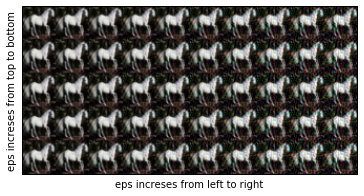

In [22]:
#grid specs rows, columns
n_r = 5
n_c = 10 

m = save_adv_e
m = m[:,selected_img_idx,:,:,:]
m_ = np.concatenate(m,axis=0)

#for noise calculation
m_0 = np.concatenate([np.concatenate([m[0] for i in range(n_c)],axis=1) for j in range(n_r)], axis = 0)

#grid of adv images
m_ = np.concatenate(m,axis=0)
m_ = np.concatenate([m_[j*n_r*32:(j+1)*n_r*32,:,:] for j in range(n_c)], axis = 1)

scipy.misc.toimage(m_, cmin=0.0).save('adv_noise.png')
plt.xlabel('eps increses from left to right')
plt.ylabel('eps increses from top to bottom')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(scipy.ndimage.imread('adv_noise.png'))

**Adversrial image for a horse (epsilon from 0.0 to 0.1 with icrements of 0.002, columnwise)**

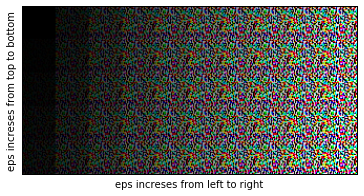

In [23]:
m_0 = np.concatenate([np.concatenate([m[0] for i in range(n_c)],axis=1) for j in range(n_r)], axis = 0)
plt.imshow(1.0*(m_-m_0))
scipy.misc.toimage(10.0*(m_-m_0), cmin=0.0).save('adv_noise_diff.png')
plt.xlabel('eps increses from left to right')
plt.ylabel('eps increses from top to bottom')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(scipy.ndimage.imread('adv_noise_diff.png'))


**The difference of adversrial image from the original image**

(50, 10000, 10)


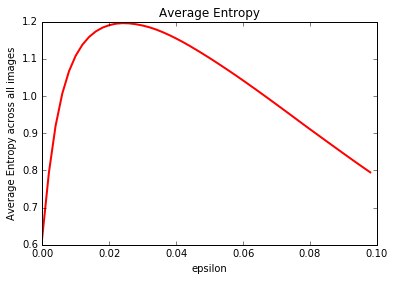

In [24]:
print(stddr_preds_e.shape)

def compute_stats(x):
    #np.mean([scipy.stats.entropy(p_vec) for p_vec in x])
    return np.sum(-x*np.log(x),axis=0)
    
stats = np.zeros((stddr_preds_e.shape[0],stddr_preds_e.shape[1]))

for i in range(stddr_preds_e.shape[0]):
    '''for every eps'''
    for j in range(stddr_preds_e.shape[1]):
        '''for every image'''
        stats[i,j] = compute_stats(stddr_preds_e[i,j,:])

plt.plot(eps,np.mean(stats,axis=1),linewidth=2,color='r')
plt.xlabel('epsilon')
plt.ylabel('Average Entropy across all images')
plt.title('Average Entropy')

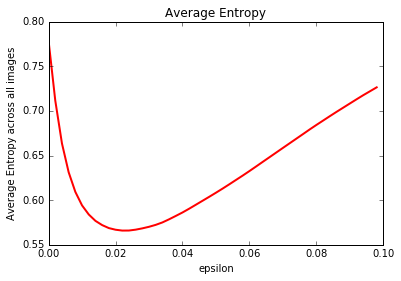

In [25]:
def compute_stats(x):
    #np.mean([scipy.stats.entropy(p_vec) for p_vec in x])
    return np.max(x)
    
stats = np.zeros((stddr_preds_e.shape[0],stddr_preds_e.shape[1]))

for i in range(stddr_preds_e.shape[0]):
    '''for every eps'''
    for j in range(stddr_preds_e.shape[1]):
        '''for every image'''
        stats[i,j] = compute_stats(stddr_preds_e[i,j,:])

plt.plot(eps,np.mean(stats,axis=1),linewidth=2,color='r')
plt.xlabel('epsilon')
plt.ylabel('Average Entropy across all images')
plt.title('Average Entropy')

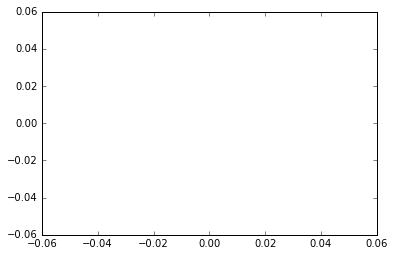

In [89]:
def compute_stats(x):
    #np.mean([scipy.stats.entropy(p_vec) for p_vec in x])
    return np.var(np.sum(-x*np.log(x),axis=1),axis=0)
    
stats = np.zeros((stoch_preds_e.shape[0],stoch_preds_e.shape[2]))

for i in range(stoch_preds_e.shape[0]):
    '''for every eps'''
    for j in range(stoch_preds_e.shape[2]):
        '''for every image'''
        stats[i,j] = compute_stats(stoch_preds_e[i,:,j,:])

plt.plot(eps,np.mean(stats,axis=1),linewidth=2,color='g',label='mc-drop')

In [7]:
from keras.utils import np_utils
def compute_stats(x):
    #shape(100,10)
    counts = np.sum(np_utils.to_categorical(np.argmax(x,axis=1), x.shape[1]),axis=0)/100.0    
    return np.var(counts)
    
stats = np.zeros((stoch_preds_e.shape[0],stoch_preds_e.shape[2]))
for i in range(stoch_preds_e.shape[0]):
    '''for every eps'''
    for j in range(stoch_preds_e.shape[2]):
        '''for every image'''
        stats[i,j] = compute_stats(stoch_preds_e[i,:,j,:])
plt.plot(eps,np.mean(stats,axis=1),linewidth=2,color='r')

KeyboardInterrupt: 

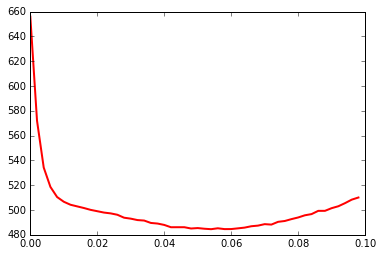

In [50]:
from keras.utils import np_utils
def compute_stats(x):
    #shape(100,10)
    mode = np.var(np.sum(np_utils.to_categorical(np.argmax(x,axis=1), x.shape[1]),axis=0))
    return mode
    
stats = np.zeros((stoch_preds_e.shape[0],stoch_preds_e.shape[2]))
for i in range(stoch_preds_e.shape[0]):
    '''for every eps'''
    for j in range(stoch_preds_e.shape[2]):
        '''for every image'''
        stats[i,j] = compute_stats(stoch_preds_e[i,:,j,:])
plt.plot(eps,np.mean(stats,axis=1),linewidth=2,color='r')

In [ ]:
stddr_preds_e[0]
model_id = 'keras_eg_alldrop'
work_dir = '/dccstor/dlw/ambrish/data/'+model_id+'/away'

stddr_preds_e1 = np.load(os.path.join(work_dir,'stddr_preds_e.npy'))
print(stddr_preds_e1[0] - stddr_preds_e[0])